<a href="https://colab.research.google.com/github/vmadalasa/EVA4S5/blob/master/Madhu_S5BasicSkeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODEL OBSERVATIONS

Target:

Get the set-up right
Set Transforms
Set Data Loader
Set Basic Working Code
Set Basic Training  & Test Loop
GET MOST BASIC MODEL WITH LESS THAN 10K params and a reasonable accuracy of 98%


Results:
Parameters: 6790
Best Training Accuracy: 99.29
Best Test Accuracy: 98.64

Analysis:
Both test and train accuracy is not enough for our purposes
Model efficiency can be increased using batch norm
Maybe we are not extracting enough information, so kernels should be changed to be better?
Model is over-fitting, so we will try to reduce overfitting

#This is to get the Basic Skeleton Right
#Since imitation is the best form of flattery, I will start with the 6K model used in class and follow the same steps
#maybe add capacity later if it doesnt work within 10k params
#Basic skeleton model, without batch norm and regularisation (dropouts)

# Input size 28X28X1; output_size = 26X26X10; RF 3X3 - Convinput 
# Input size 26X26X10; output_size = 24X24X10; RF 5X5 - convblock1A
# Input size 24X24X10; output_size = 22X22X10; RF 7X7 - convblock1B

#Now Max pool to get this to Input size 22X22X10; output_size = 11X11X20; RF 14X14 - pool1
# Input size 11X11X20; output_size = 11X11X10; RF 14X14 - tranblock1

#Convblock 2
# Input size 11X11X10; output_size = 9X9X10; RF 16X16 - convblock2A
# Input size 9X9X10; output_size = 7X7X10; RF 18X18 - convblock2B
# Input size 7X7X10; output_size = 5X5X20; RF 20X20 - convblock2C

#Now we have reached only till RF of 20X20
#We do self.gap layer at kernel size 5 - gap
#finally transblock 1X1 for Input size 1X1X16; output_size = 1X1X10; RF 20X20 - convblockEnd

BATCH SIZE = 128

NO ROTATION OF IMAGES


# OBSERVATIONS
We find accuracy of  11%  (train accuracy) in the first epoch
Rises to about 98.5 towards epoch 15
in some epochs, we find overfitting. 

Not bad for a starting model
We will try batch norm as next step




In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#This is to get the Basic Skeleton Right
#Since imitation is the best form of flattery, I will start with the 6K model used in class and follow the same steps
#maybe add capacity later if it doesnt work within 10k params
#Basic skeleton model, without batch norm and regularisation (dropouts)

# Input size 28X28X1; output_size = 26X26X10; RF 3X3 - Convinput 
# Input size 26X26X10; output_size = 24X24X10; RF 5X5 - convblock1A
# Input size 24X24X10; output_size = 22X22X10; RF 7X7 - convblock1B

#Now Max pool to get this to Input size 22X22X10; output_size = 11X11X20; RF 14X14 - pool1
# Input size 11X11X20; output_size = 11X11X10; RF 14X14 - tranblock1

#Convblock 2
# Input size 11X11X10; output_size = 9X9X10; RF 16X16 - convblock2A
# Input size 9X9X10; output_size = 7X7X10; RF 18X18 - convblock2B
# Input size 7X7X10; output_size = 5X5X20; RF 20X20 - convblock2C

#Now we have reached only till RF of 20X20
#We do self.gap layer at kernel size 5 - gap
#finally transblock 1X1 for Input size 1X1X16; output_size = 1X1X10; RF 20X20 - convblockEnd





class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        # Input Block
        self.convinput = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # Input size 28X28X1; output_size = 26X26X10; RF 3X3

       # CONVOLUTION BLOCK 1
        self.convblock1A = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # Input size 26X26X10; output_size = 24X24X10; RF 5X5

        self.convblock1B = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # Input size 24X24X10; output_size = 22X22X10; RF 7X7

    

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # # Input size 22X22X20; output_size = 11X11X20; RF 14X14
        
        self.tranblock1 = nn.Sequential(
           nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # # Input size 11X11X20; output_size = 11X11X10; RF 14X14

      # CONVOLUTION BLOCK 2
        self.convblock2A = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # Input size 11X11X10; output_size = 9X9X10; RF 16X16

 
        self.convblock2B = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),   
        ) # # Input size 9X9X10; output_size = 7X7X10; RF 18X18

        self.convblock2C = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  
        ) # # Input size 7X7X10; output_size = 5X5X20; RF 20X20


      # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblockEnd = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value) 

        ) #Input size 1X1X20; output_size = 1X1X10; RF 20X20


    def forward(self, x):
        x = self.convinput(x)

        x = self.convblock1A(x)
        x = self.convblock1B(x)
        
        x = self.pool1(x)
        #x = self.poolAlt1(x)
        x = self.tranblock1(x)

        x = self.convblock2A(x)
        x = self.convblock2B(x)
        x = self.convblock2C(x)

        x = self.gap(x)        
       
        x = self.convblockEnd(x)
        #print(x.shape)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        
        
     

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
            Conv2d-9             [-1, 10, 9, 9]             900
             ReLU-10             [-1, 10, 9, 9]               0
           Conv2d-11             [-1, 10, 7, 7]             900
             ReLU-12             [-1, 10, 7, 7]               0
           Conv2d-13             [-1, 20, 5, 5]           1,800
             ReLU-14             [-1, 2

In [0]:
#WHAT WE CHANGE IN THIS BLOCK
#BATCHSIZE = 128 IN BASIC SKELETON MODEL
#NO ROTATION

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-9.0, 9.0), fill=(1,)),                    
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)




CUDA Available? True


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    print('Epoch', epoch, ' done')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=2.302431344985962 Batch_id=468 Accuracy=10.40: 100%|██████████| 469/469 [00:10<00:00, 42.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1193/10000 (11.93%)

Epoch 1  done
EPOCH: 2


Loss=2.302222728729248 Batch_id=468 Accuracy=12.64: 100%|██████████| 469/469 [00:10<00:00, 46.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 1210/10000 (12.10%)

Epoch 2  done
EPOCH: 3


Loss=1.0469337701797485 Batch_id=468 Accuracy=16.09: 100%|██████████| 469/469 [00:10<00:00, 44.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0601, Accuracy: 6623/10000 (66.23%)

Epoch 3  done
EPOCH: 4


Loss=0.3033347427845001 Batch_id=468 Accuracy=86.01: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2315, Accuracy: 9276/10000 (92.76%)

Epoch 4  done
EPOCH: 5


Loss=0.047211918979883194 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:10<00:00, 45.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1393, Accuracy: 9576/10000 (95.76%)

Epoch 5  done
EPOCH: 6


Loss=0.16993367671966553 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:10<00:00, 45.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1014, Accuracy: 9704/10000 (97.04%)

Epoch 6  done
EPOCH: 7


Loss=0.05015810951590538 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:10<00:00, 45.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9791/10000 (97.91%)

Epoch 7  done
EPOCH: 8


Loss=0.07431329041719437 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:10<00:00, 46.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9786/10000 (97.86%)

Epoch 8  done
EPOCH: 9


Loss=0.13466545939445496 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:10<00:00, 45.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9806/10000 (98.06%)

Epoch 9  done
EPOCH: 10


Loss=0.12213965505361557 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:10<00:00, 45.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9840/10000 (98.40%)

Epoch 10  done
EPOCH: 11


Loss=0.050079282373189926 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9825/10000 (98.25%)

Epoch 11  done
EPOCH: 12


Loss=0.0737246572971344 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:10<00:00, 44.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9838/10000 (98.38%)

Epoch 12  done
EPOCH: 13


Loss=0.15269316732883453 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:10<00:00, 45.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9852/10000 (98.52%)

Epoch 13  done
EPOCH: 14


Loss=0.08633055537939072 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9842/10000 (98.42%)

Epoch 14  done
EPOCH: 15


Loss=0.05298151075839996 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 45.26it/s]



Test set: Average loss: 0.0400, Accuracy: 9869/10000 (98.69%)

Epoch 15  done


Text(0.5, 1.0, 'Test Accuracy')

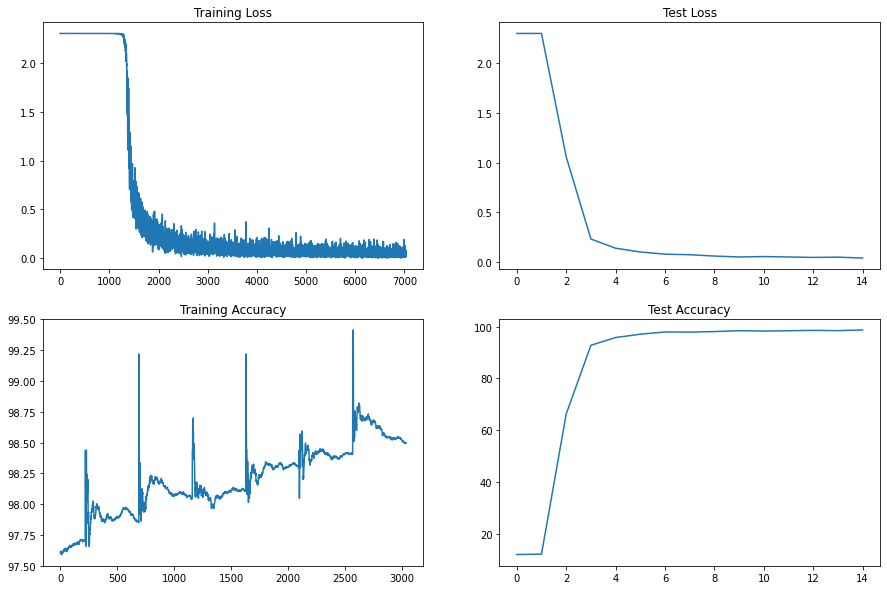

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")